In [ ]:
%%capture
%cd drive/MyDrive/DS/Sentiment-Analysis/NLP\ with\ Disaster
!pip install torch --index-url https://download.pytorch.org/whl/cpu
!pip install sentence-transformers
!pip install transformers
!pip install tensorflow
!pip install tensorflow_hub
!pip install tf-keras
!pip install symspellpy

In [ ]:
# Standard Library Imports
import os                      # For file and directory operations
import zipfile                 # For extracting compressed dataset files
import string                  # Provides common string operations and punctuation lists
import regex as re             # Regular expressions for text cleaning and pattern matching

# Data and Numerical Libraries
import numpy as np             # Numerical computations and array operations
import pandas as pd            # Data manipulation and analysis (DataFrames)

# Natural Language Processing (NLP)
import spacy                   # For tokenization, lemmatization, and named entity recognition
from sentence_transformers import SentenceTransformer  # For sentence embeddings using pretrained transformer models
from sklearn.metrics.pairwise import cosine_similarity  # To compute similarity between sentence embeddings
from symspellpy import SymSpell, Verbosity             # For fast spell correction using SymSpell

# Deep Learning and Model Building
import tensorflow as tf
import tensorflow_hub as hub     # To load pre-trained embedding models from TensorFlow Hub
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, concatenate  # for neural network construction
from tensorflow.keras import Model               # For defining custom multi-input models
from tensorflow.keras.callbacks import EarlyStopping

# Model Evaluation and Data Handling
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Performance metrics
from sklearn.utils import shuffle                # Shuffle datasets for randomness
from sklearn.model_selection import train_test_split  # Split dataset into training and validation sets

# Visualization
import matplotlib.pyplot as plt


LOCAL_ZIP = "data.zip"
EXTRACT_DIR = "/tmp"

if os.path.exists(LOCAL_ZIP):
    with zipfile.ZipFile(LOCAL_ZIP, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print(f"Extracted '{LOCAL_ZIP}' to '{EXTRACT_DIR}'")
else:
    print(f"File '{LOCAL_ZIP}' not found.")

# Ensure spaCy English model is available
SPACY_MODEL = "en_core_web_sm"
try:
    nlp = spacy.load(SPACY_MODEL)
except OSError:
    os.system(f"python -m spacy download {SPACY_MODEL}")
    nlp = spacy.load(SPACY_MODEL)

# Initialize SymSpell for spell correction
sym_spell = SymSpell()
DICTIONARY_PATH = "./frequency_dictionary_en_82_765.txt.txt"

if os.path.exists(DICTIONARY_PATH):
    sym_spell.load_dictionary(DICTIONARY_PATH, term_index=0, count_index=1)
else:
    raise FileNotFoundError(f"Dictionary file not found at {DICTIONARY_PATH}")

# Load pre-trained sentence embeddings model for keyword extraction
sentence_model = SentenceTransformer('distilbert-base-nli-mean-tokens')


Extracted 'data.zip' to '/tmp'


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
TRAIN_PATH = "/tmp/train.csv"
TEST_PATH = "/tmp/test.csv"

def load_dataset(path: str) -> pd.DataFrame:
    """Load a CSV dataset safely with pandas."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)

# Load datasets
train = load_dataset(TRAIN_PATH)
test = load_dataset(TEST_PATH)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train shape: (7613, 5)
Test shape: (3263, 4)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train.sample(5)

,id,keyword,location,text,target
2996,4304,dust%20storm,"Lubbock, TX",Severe storm weakening as it moves SE towards ...,1
3165,4543,emergency,NaN,@chowtaxis of Newport a big thanks for the eme...,1
6230,8893,snowstorm,Wakefield MA,Manuel hoping for an early Buffalo snowstorm s...,1
948,1374,blown%20up,NaN,Turn on ESPN2 and get blown up,0
1443,2081,casualty,Virginia,@AvBronstein @Popehat @instapundit @KurtSchlic...,1


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [ ]:
test.sample(5)

,id,keyword,location,text
2355,7879,quarantined,NaN,http://t.co/AyLATPE073 Reddit's new content po...
528,1732,buildings%20burning,NaN,@CTVKathyLe and in other news: don't run into ...
1371,4510,emergency,New York,11000 SEEDS 30 VEGETABLE FRUIT VARIETY GARDEN ...
1109,3668,destroy,NaN,People can't destroy you unless you let them.
3028,9999,tsunami,NaN,This high-tech sphere can be the key to saving...


In [ ]:
train[train['target']==1].size

16355

In [ ]:
train[train['target']==0].size

21710

In [ ]:
# Preprocessing Functions

def convert_text_columns_to_lower(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Convert text columns to lowercase"""
    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: str(x).lower() if pd.notna(x) else x)
    return df

def remove_entities_from_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Remove mentions (@), hashtags (#), and most punctuation from selected text columns."""
    entity_prefixes = {"@", "#"}

    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda text: (
                    " ".join(
                        word.strip()
                        for word in str(text).split()
                        if word and word[0] not in entity_prefixes
                    )
                    .translate(str.maketrans({sep: " " for sep in string.punctuation if sep not in entity_prefixes}))
                    if pd.notna(text) else text
                )
            )
    return df

def remove_urls_from_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Remove URLs and mentions from selected text columns."""
    url_pattern = r"(?:\@|http?\://|https?\://|www)\S+"

    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda x: re.sub(url_pattern, " ", str(x)) if pd.notna(x) else x
            )
    return df

def remove_punctuation_from_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """Remove punctuation from selected text columns, keeping only words and spaces."""
    pattern = r"[^\w\s]"

    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(
                lambda x: re.sub(pattern, " ", str(x)) if pd.notna(x) else x
            )
    return df

def correct_spelling_in_columns(df: pd.DataFrame, columns: list, max_edit_distance: int = 2) -> pd.DataFrame:
    """Correct spelling in selected text columns using SymSpell (flat function, no nested functions)."""
    for col in columns:
        if col in df.columns:
            corrected_texts = []
            for text in df[col]:
                if pd.isna(text):
                    corrected_texts.append(text)
                    continue
                corrected_words = []
                for word in str(text).split():
                    suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=max_edit_distance, include_unknown=True)
                    if suggestions:
                        corrected_words.append(str(suggestions[0]).split(',')[0])
                    else:
                        corrected_words.append(word)
                corrected_texts.append(" ".join(corrected_words))
            df[col] = corrected_texts
    return df

def fill_missing_keywords(df: pd.DataFrame, text_col: str = "text", keyword_col: str = "keyword",
                          nlp=nlp, model=sentence_model, no_of_keywords: int = 1) -> pd.DataFrame:
    """
    Fill missing keywords in a dataframe using NLP + sentence embeddings.
    Extracts keywords based on POS tags and embedding similarity.
    """
    pos_tags = {"VERB", "NOUN", "ADJ", "PROPN"}

    for i in range(len(df)):
        if pd.isna(df[keyword_col].iloc[i]):
            try:
                doc_text = str(df[text_col].iloc[i]).lower()
                doc_text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+', ' ', doc_text)
                doc_text = re.sub(r'[^\w\s]', ' ', doc_text)
                doc_text = re.sub(r'\d+', ' ', doc_text)

                doc_nlp = nlp(doc_text)

                # Collect candidate tokens based on POS
                candidates = [token.text for token in doc_nlp if token.pos_ in pos_tags]

                if candidates:
                    doc_embedding = model.encode([doc_text])
                    candidate_embeddings = model.encode(candidates)
                    distances = cosine_similarity(doc_embedding, candidate_embeddings)
                    # Select top keyword(s)
                    top_indices = distances.argsort()[0][-no_of_keywords:]
                    df[keyword_col].iloc[i] = candidates[top_indices[-1]]
                else:
                    df[keyword_col].iloc[i] = "NaN"

            except Exception:
                df[keyword_col].iloc[i] = "NaN"

    return df

def fill_missing_locations(df: pd.DataFrame, text_col: str = "text", location_col: str = "location", nlp=nlp) -> pd.DataFrame:
    """
    Fill missing locations in a dataframe using Named Entity Recognition (NER).
    Extracts Geopolitical Entities (GPE) and Organizations (ORG) from text.
    """
    for i in range(len(df)):
        if pd.isna(df[location_col].iloc[i]):
            try:
                doc_text = str(df[text_col].iloc[i])
                doc_nlp = nlp(doc_text)

                # Collect GPE and ORG entities
                entities = [ent.text for ent in doc_nlp.ents if ent.label_ in ["GPE", "ORG"]]
                df[location_col].iloc[i] = " ".join(entities) if entities else "NaN"

            except Exception:
                df[location_col].iloc[i] = "NaN"

    return df


def lemmatize_columns(df: pd.DataFrame, columns: list, nlp=nlp) -> pd.DataFrame:
    """
    Lemmatize text in selected columns using spaCy.
    """
    for col in columns:
        if col in df.columns:
            lemmatized_texts = []
            for text in df[col]:
                if pd.isna(text):
                    lemmatized_texts.append(text)
                else:
                    doc = nlp(str(text))
                    lemmatized_texts.append(" ".join([token.lemma_ for token in doc]))
            df[col] = lemmatized_texts
    return df

def remove_stopwords_from_columns(df: pd.DataFrame, columns: list, nlp=nlp) -> pd.DataFrame:
    """
    Remove stopwords from selected text columns using spaCy's default stopword list.
    """
    all_stopwords = nlp.Defaults.stop_words

    for col in columns:
        if col in df.columns:
            cleaned_texts = []
            for text in df[col]:
                if pd.isna(text):
                    cleaned_texts.append(text)
                else:
                    doc = nlp(str(text))
                    tokens_without_sw = [token.text for token in doc if token.text not in all_stopwords]
                    cleaned_texts.append(" ".join(tokens_without_sw))
            df[col] = cleaned_texts
    return df

In [ ]:
%%capture
text_columns = ["keyword", "location", "text"]

def preprocess_dataset(df, text_columns, nlp, model):
    """
    Complete preprocessing pipeline for disaster tweet dataset.
    """
    return (
        df
        .pipe(convert_text_columns_to_lower, text_columns)
        .pipe(remove_entities_from_columns, text_columns)
        .pipe(remove_urls_from_columns, text_columns)
        .pipe(remove_punctuation_from_columns, text_columns)
        .pipe(correct_spelling_in_columns, text_columns)
        .pipe(fill_missing_keywords, text_col="text", keyword_col="keyword", nlp=nlp, model=model)
        .pipe(fill_missing_locations, text_col="text", location_col="location", nlp=nlp)
        .pipe(lemmatize_columns, text_columns, nlp=nlp)
        .pipe(remove_stopwords_from_columns, text_columns, nlp=nlp)
    )

# Apply preprocessing to train and test
train = preprocess_dataset(train, text_columns, nlp=nlp, model=sentence_model)
test = preprocess_dataset(test, text_columns, nlp=nlp, model=sentence_model)

print("Full preprocessing pipeline applied to train and test datasets.")


In [ ]:
# Load pre-trained TensorFlow Hub embedding model
TFHUB_MODEL_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(TFHUB_MODEL_URL)

print(f"Loaded TensorFlow Hub model from {TFHUB_MODEL_URL}")

Loaded TensorFlow Hub model from https://tfhub.dev/google/universal-sentence-encoder/4


In [ ]:
# Shuffle the dataset
train = shuffle(train, random_state=42).reset_index(drop=True)

# Extract target column
TARGET_COL = "target"
if TARGET_COL in train.columns:
    y = train[TARGET_COL].to_numpy()
else:
    raise KeyError(f"Column '{TARGET_COL}' not found in the dataset.")

# Separate features from target
X = train.drop(columns=[TARGET_COL])

# Split into training and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dataset split: {len(X_train)} training samples, {len(X_test)} validation samples.")


Dataset split: 6090 training samples, 1523 validation samples.


In [ ]:
# Embeddings for train dataset
key_embed = embed(X_train.keyword.to_list())     # Keyword embeddings
loc_embed = embed(X_train.location.to_list())   # Location embeddings
text_embed = embed(X_train.text.to_list())      # Text embeddings

# Define input layers
keyword_input = Input(shape=(key_embed.shape[1],), name="keyword_input")
location_input = Input(shape=(loc_embed.shape[1],), name="location_input")
text_input = Input(shape=(text_embed.shape[1],), name="text_input")

# Helper function to create sub-models for each input
def create_submodel(input_layer):
    x = Flatten()(input_layer)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    return x

# Create sub-models
key_model = create_submodel(keyword_input)
loc_model = create_submodel(location_input)
text_model = create_submodel(text_input)

# Concatenate sub-models
merged = concatenate([key_model, loc_model, text_model], axis=1)
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.5)(merged)

# Final output
output = Dense(1, activation='sigmoid', name="output")(merged)

# Create model
final_model = Model(inputs=[keyword_input, location_input, text_input], outputs=output)

# Optimizer
learning_rate = 1e-5
epochs = 300
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile model
final_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

final_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keyword_input       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ location_input      │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ keyword_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 512)       │          0 │ location_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 512)       │          0 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    262,656 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1536)      │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0],  │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    786,944 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        513 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,575,425 (6.01 MB)

 Trainable params: 1,575,425 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
final_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

earlystop = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = final_model.fit(
    x=[key_embed, loc_embed, text_embed],
    y=y_train,
    batch_size=32,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[earlystop]
)


Epoch 1/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5371 - loss: 0.6906 - val_accuracy: 0.5616 - val_loss: 0.6828
Epoch 2/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5734 - loss: 0.6815 - val_accuracy: 0.5616 - val_loss: 0.6747
Epoch 3/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5741 - loss: 0.6720 - val_accuracy: 0.5616 - val_loss: 0.6664
Epoch 4/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5651 - loss: 0.6666 - val_accuracy: 0.5616 - val_loss: 0.6567
Epoch 5/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5913 - loss: 0.6539 - val_accuracy: 0.6125 - val_loss: 0.6446
Epoch 6/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6117 - loss: 0.6461 - val_accuracy: 0.6864 - val_loss: 0.6291
Epoch 7/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6574 - loss: 0.6343 - val_accuracy: 0.7307 - val_loss: 0.6105
Epoch 8/300
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7032 - loss: 0.6137 - val_ac

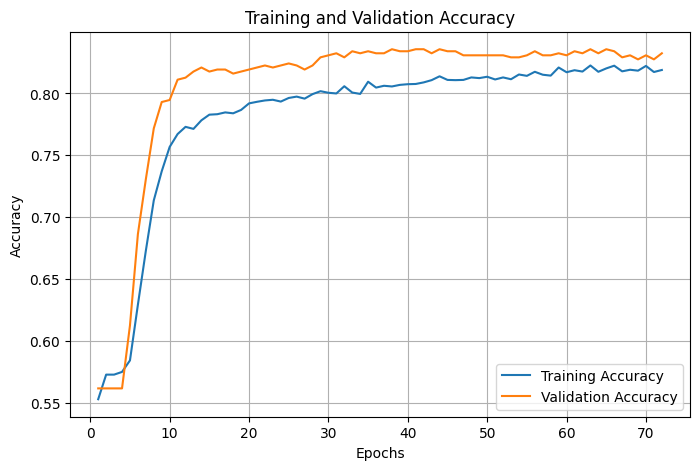

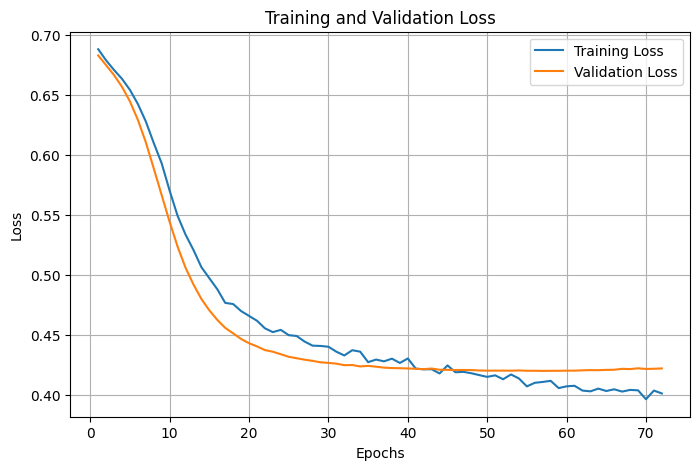

In [ ]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss from Keras history object
    """
    # Extract metrics
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs_range = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.show()


# Call the plotting function
plot_training_history(history)

In [ ]:
# Embeddings for evaluation and prediction

# Validation/Test data with known target values (used for model evaluation and metric calculation)
X_test_key_embed = embed(X_test.keyword.to_list())   # Embeddings for 'keyword' column
X_test_loc_embed = embed(X_test.location.to_list())  # Embeddings for 'location' column
X_test_text_embed = embed(X_test.text.to_list())     # Embeddings for 'text' column

# Unlabeled test data (used for generating final predictions)
test_key_embed = embed(test.keyword.to_list())       # Embeddings for 'keyword' column
test_loc_embed = embed(test.location.to_list())      # Embeddings for 'location' column
test_text_embed = embed(test.text.to_list())         # Embeddings for 'text' column

In [ ]:
X_test_results = final_model.predict([X_test_key_embed, X_test_loc_embed, X_test_text_embed])
X_test_results = X_test_results.tolist()

test_results = final_model.predict([test_key_embed, test_loc_embed, test_text_embed])
test_results = test_results.tolist()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
test_predictions = [1 if test_result[0] > 0.5 else 0 for test_result in test_results]
X_test_predictions = [1 if X_test_result[0] > 0.5 else 0 for X_test_result in X_test_results]

# Calculate accuracy
test_accuracy = accuracy_score(y_test, X_test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

# More detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, X_test_predictions, digits=4))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, X_test_predictions))


Test Accuracy: 0.8030

Classification Report:
              precision    recall  f1-score   support

           0     0.8165    0.8446    0.8303       869
           1     0.7837    0.7477    0.7653       654

    accuracy                         0.8030      1523
   macro avg     0.8001    0.7962    0.7978      1523
weighted avg     0.8024    0.8030    0.8024      1523


Confusion Matrix:
[[734 135]
 [165 489]]


In [ ]:
test["target_results"] = test_predictions

In [ ]:
test.sample(10)

,id,keyword,location,text,target_results
134,425,apocalypse,currently earth,honestly apocalypse come I exit s enthusiastic,0
2498,8328,rubble,management multimedia,china stock market crash summer spark interest...,0
2398,8022,refugee,toulouse hate garonne france,story couple spend wedding day feed 4000 syria...,1
765,2509,collision,feed,car feed sex truck head collision I mile marke...,1
113,376,annihilation,NaN,I I iced annihilation,0
2010,6768,lightning,NaN,southeast regional lightning delay buckle folk...,1
331,1076,bleed,windy city land snake,want I quit I bleed,0
2902,9621,thunderstorm,orc,new event severe thunderstorm warning 2015 pm ...,1
2231,7441,obliterate,good middlesbrough,drake absolutely obliterate meek mill,0
164,541,army,NaN,direction pick help co q2eblokeve fan army hel...,0
